In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *
from encoding_information.plot_utils import *

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-29 21:46:52.460619: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 21:46:53.176464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-29 21:46:53.176537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-29 21:46:53.176545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


In [2]:
# load images, extract patches, and compute cov mats
edge_crop = 32
num_images = 20000
num_patches = 20000
channel = 'LED119'

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=True)
all_images = add_noise(all_images)
images = all_images[:num_images]
test_images = all_images[num_images:]


In [3]:
patch_sizes = [1, 2, 3, 5, 10, 20, 35, 50]
num_samples = 8
sample_size = 80
eigenvalue_floor = 1e-1


# patch_sizes = [1, 5, 10]
# num_samples = 8
# sample_size = 40


# load train and test patches corresponding to the biggest patch size
patches = extract_patches(images, patch_sizes[-1], num_patches=num_patches, seed=0, verbose=True)
test_patches = extract_patches(test_images, patch_sizes[-1], num_patches=num_test_images, seed=0, verbose=True)


test_set_NLL_gp = {}
test_set_NLL_pixel_cnn = {}
mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
samples = {}
for patch_size in tqdm(patch_sizes, desc='patch sizes'):
    # take a random sub crop from the patchs
    subpatches = extract_patches(patches, patch_size, num_patches=num_patches, seed=0, verbose=False)
    test_subpatches = extract_patches(test_patches, patch_size, num_patches=num_test_images, seed=0, verbose=False)

    mi_estimates_gp[patch_size], stationary_gp = estimate_mutual_information(
        subpatches, eigenvalue_floor=eigenvalue_floor, use_iterative_optimization=True, return_entropy_model=True,
        verbose=True)
    test_set_NLL_gp[patch_size] = stationary_gp.compute_negative_log_likelihood(test_subpatches)

    mi_estimates_pixel_cnn[patch_size], pixel_cnn = estimate_mutual_information(
        subpatches, entropy_model='pixelcnn', return_entropy_model=True, verbose=True)
    test_set_NLL_pixel_cnn[patch_size] = pixel_cnn.compute_negative_log_likelihood(test_subpatches)

    samples[patch_size] = {}
    print('generating samples GP')
    samples[patch_size]['GP'] = stationary_gp.generate_samples(num_samples=num_samples, sample_shape=sample_size, seed=None)
    print('generating samples PixelCNN')
    samples[patch_size]['PixelCNN'] = pixel_cnn.generate_samples(num_samples=num_samples, sample_shape=sample_size, seed=None)

print('GP MI estimates', mi_estimates_gp)
print('PixelCNN MI estimates', mi_estimates_pixel_cnn)

patch sizes:   0%|                                               | 0/8 [00:00<?, ?it/s]2023-10-29 21:53:35.194883: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 6.21



Epoch 1: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 1: validation NLL: 6.21



Epoch 2: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 245.09it/s]


Epoch 2: validation NLL: 6.21



Epoch 3: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 276.16it/s]


Epoch 3: validation NLL: 6.21



Epoch 4: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 300.93it/s]


Epoch 4: validation NLL: 6.21



Epoch 5: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 299.46it/s]


Epoch 5: validation NLL: 6.21



Epoch 6: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 253.94it/s]


Epoch 6: validation NLL: 6.21



Epoch 7: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 351.08it/s]


Epoch 7: validation NLL: 6.21



Epoch 8: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 335.06it/s]


Epoch 8: validation NLL: 6.21



Epoch 9: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 245.81it/s]


Epoch 9: validation NLL: 6.21



Epoch 10: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 215.38it/s]


Epoch 10: validation NLL: 6.21



Epoch 11: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 332.64it/s]


Epoch 11: validation NLL: 6.21



Epoch 12: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 321.38it/s]


Epoch 12: validation NLL: 6.21



Epoch 13: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 253.66it/s]


Epoch 13: validation NLL: 6.21



Epoch 14: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 313.38it/s]


Epoch 14: validation NLL: 6.21



Epoch 15: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 322.96it/s]


Epoch 15: validation NLL: 6.21



Epoch 16: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 260.22it/s]


Epoch 16: validation NLL: 6.21



Epoch 17: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 256.41it/s]


Epoch 17: validation NLL: 6.21



precomputing masks and variances: 100%|██████████████████| 1/1 [00:00<00:00, 48.03it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████████| 1/1 [00:00<00:00, 325.14it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 6.252 differential entropy/pixel
Estimated I(Y;X) = 2.717 bits/pixel



precomputing masks and variances: 100%|█████████████████| 1/1 [00:00<00:00, 915.19it/s]

evaluating likelihood




computing log likelihoods: 100%|████████████████████████| 1/1 [00:00<00:00, 377.93it/s]


Initial validation NLL: 139.54



Epoch 1: 100%|███████████████████████████████████████| 100/100 [00:07<00:00, 14.26it/s]


Epoch 1: validation NLL: 6.26



Epoch 2: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 134.46it/s]


Epoch 2: validation NLL: 6.28



Epoch 3: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 143.49it/s]


Epoch 3: validation NLL: 6.26



Epoch 4: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 149.29it/s]


Epoch 4: validation NLL: 6.26



Epoch 5: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 144.40it/s]


Epoch 5: validation NLL: 6.26



Epoch 6: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 154.15it/s]


Epoch 6: validation NLL: 6.26



Epoch 7: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 143.05it/s]


Epoch 7: validation NLL: 6.26



Epoch 8: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 147.28it/s]


Epoch 8: validation NLL: 6.26



Epoch 9: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 149.51it/s]


Epoch 9: validation NLL: 6.26



Epoch 10: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 143.79it/s]


Epoch 10: validation NLL: 6.26



Epoch 11: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 149.09it/s]


Epoch 11: validation NLL: 6.26



Epoch 12: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 145.21it/s]


Epoch 12: validation NLL: 6.26



Epoch 13: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 146.72it/s]


Epoch 13: validation NLL: 6.26



Computing loss: 100%|████████████████████████████████| 126/126 [00:03<00:00, 33.22it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 6.252 differential entropy/pixel
Estimated I(Y;X) = 2.717 bits/pixel



Computing loss: 100%|█████████████████████████████████| 63/63 [00:00<00:00, 178.83it/s]


generating samples GP



precomputing masks and variances: 100%|████████████████| 80/80 [01:53<00:00,  1.42s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████████| 80/80 [01:49<00:00,  1.37s/it]


generating samples PixelCNN



patch sizes:  12%|████▍                              | 1/8 [29:30<3:26:31, 1770.15s/it]

Initial validation NLL: 5.37



Epoch 1: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


Epoch 1: validation NLL: 5.37



Epoch 2: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 282.67it/s]


Epoch 2: validation NLL: 5.37



Epoch 3: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 304.64it/s]


Epoch 3: validation NLL: 5.37



Epoch 4: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 317.51it/s]


Epoch 4: validation NLL: 5.37



Epoch 5: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 205.58it/s]


Epoch 5: validation NLL: 5.37



precomputing masks and variances: 100%|██████████████████| 2/2 [00:00<00:00, 26.28it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████████| 2/2 [00:00<00:00, 604.45it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.426 differential entropy/pixel
Estimated I(Y;X) = 1.527 bits/pixel



precomputing masks and variances: 100%|█████████████████| 2/2 [00:00<00:00, 608.00it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████████| 2/2 [00:00<00:00, 602.89it/s]


Initial validation NLL: 125.61



Epoch 1: 100%|███████████████████████████████████████| 100/100 [00:06<00:00, 16.41it/s]


Epoch 1: validation NLL: 6.01



Epoch 2: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 156.91it/s]


Epoch 2: validation NLL: 5.47



Epoch 3: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 172.06it/s]


Epoch 3: validation NLL: 5.42



Epoch 4: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 175.30it/s]


Epoch 4: validation NLL: 5.45



Epoch 5: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 156.27it/s]


Epoch 5: validation NLL: 5.44



Epoch 6: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 180.78it/s]


Epoch 6: validation NLL: 5.54



Epoch 7: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 164.71it/s]


Epoch 7: validation NLL: 5.40



Epoch 8: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 172.86it/s]


Epoch 8: validation NLL: 5.41



Epoch 9: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 171.66it/s]


Epoch 9: validation NLL: 5.40



Epoch 10: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 182.21it/s]


Epoch 10: validation NLL: 5.53



Epoch 11: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 185.82it/s]


Epoch 11: validation NLL: 5.40



Epoch 12: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 179.73it/s]


Epoch 12: validation NLL: 5.43



Epoch 13: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 178.15it/s]


Epoch 13: validation NLL: 5.41



Epoch 14: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 166.51it/s]


Epoch 14: validation NLL: 5.40



Epoch 15: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 167.16it/s]


Epoch 15: validation NLL: 5.41



Epoch 16: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 175.14it/s]


Epoch 16: validation NLL: 5.43



Epoch 17: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 171.91it/s]


Epoch 17: validation NLL: 5.41



Computing loss: 100%|████████████████████████████████| 126/126 [00:03<00:00, 34.55it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.441 differential entropy/pixel
Estimated I(Y;X) = 1.548 bits/pixel



Computing loss: 100%|█████████████████████████████████| 63/63 [00:00<00:00, 259.05it/s]


generating samples GP



precomputing masks and variances: 100%|████████████████| 80/80 [01:57<00:00,  1.46s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████████| 80/80 [01:46<00:00,  1.33s/it]


generating samples PixelCNN



patch sizes:  25%|████████▊                          | 2/8 [57:06<2:50:18, 1703.13s/it]

Initial validation NLL: 5.18



Epoch 1: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 1: validation NLL: 5.18



Epoch 2: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 237.49it/s]


Epoch 2: validation NLL: 5.18



Epoch 3: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 317.87it/s]


Epoch 3: validation NLL: 5.18



Epoch 4: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 234.44it/s]


Epoch 4: validation NLL: 5.18



Epoch 5: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 154.79it/s]


Epoch 5: validation NLL: 5.18



Epoch 6: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 183.12it/s]


Epoch 6: validation NLL: 5.18



Epoch 7: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 249.51it/s]


Epoch 7: validation NLL: 5.18



Epoch 8: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 323.11it/s]


Epoch 8: validation NLL: 5.18



precomputing masks and variances: 100%|██████████████████| 3/3 [00:00<00:00, 36.81it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████████| 3/3 [00:00<00:00, 510.63it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.188 differential entropy/pixel
Estimated I(Y;X) = 1.183 bits/pixel



precomputing masks and variances: 100%|█████████████████| 3/3 [00:00<00:00, 538.91it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████████| 3/3 [00:00<00:00, 581.92it/s]


Initial validation NLL: 132.94



Epoch 1: 100%|███████████████████████████████████████| 100/100 [00:06<00:00, 15.07it/s]


Epoch 1: validation NLL: 6.06



Epoch 2: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 165.08it/s]


Epoch 2: validation NLL: 5.53



Epoch 3: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 172.09it/s]


Epoch 3: validation NLL: 5.37



Epoch 4: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 176.03it/s]


Epoch 4: validation NLL: 5.30



Epoch 5: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 167.08it/s]


Epoch 5: validation NLL: 5.29



Epoch 6: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 162.16it/s]


Epoch 6: validation NLL: 5.26



Epoch 7: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 156.10it/s]


Epoch 7: validation NLL: 5.24



Epoch 8: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 169.47it/s]


Epoch 8: validation NLL: 5.24



Epoch 9: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 160.03it/s]


Epoch 9: validation NLL: 5.25



Epoch 10: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 155.85it/s]


Epoch 10: validation NLL: 5.24



Epoch 11: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 166.86it/s]


Epoch 11: validation NLL: 5.24



Epoch 12: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 172.01it/s]


Epoch 12: validation NLL: 5.25



Epoch 13: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 160.28it/s]


Epoch 13: validation NLL: 5.23



Epoch 14: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 159.66it/s]


Epoch 14: validation NLL: 5.21



Epoch 15: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 155.97it/s]


Epoch 15: validation NLL: 5.24



Epoch 16: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 151.63it/s]


Epoch 16: validation NLL: 5.23



Epoch 17: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 147.63it/s]


Epoch 17: validation NLL: 5.22



Epoch 18: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 162.81it/s]


Epoch 18: validation NLL: 5.21



Epoch 19: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 153.10it/s]


Epoch 19: validation NLL: 5.20



Epoch 20: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 166.67it/s]


Epoch 20: validation NLL: 5.23



Epoch 21: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 165.96it/s]


Epoch 21: validation NLL: 5.20



Epoch 22: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 173.24it/s]


Epoch 22: validation NLL: 5.24



Epoch 23: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 172.51it/s]


Epoch 23: validation NLL: 5.21



Epoch 24: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 175.63it/s]


Epoch 24: validation NLL: 5.23



Epoch 25: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 169.37it/s]


Epoch 25: validation NLL: 5.20



Epoch 26: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 165.34it/s]


Epoch 26: validation NLL: 5.22



Epoch 27: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 152.26it/s]


Epoch 27: validation NLL: 5.20



Epoch 28: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 155.91it/s]


Epoch 28: validation NLL: 5.21



Epoch 29: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 164.92it/s]


Epoch 29: validation NLL: 5.20



Epoch 30: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 162.53it/s]


Epoch 30: validation NLL: 5.22



Epoch 31: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 163.63it/s]


Epoch 31: validation NLL: 5.20



Computing loss:   0%|                                          | 0/126 [00:00<?, ?it/s]2023-10-29 22:51:29.222650: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-29 22:51:29.222678: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,3,3]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Computing loss:  82%|██████████████████████████▏     | 103/126 [00:02<00:00, 97.31it/s]2023-10-29 22:51:31.317858: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-29 22:51:31.317888: W external/x

Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.188 differential entropy/pixel
Estimated I(Y;X) = 1.183 bits/pixel



Computing loss: 100%|█████████████████████████████████| 63/63 [00:00<00:00, 250.77it/s]


generating samples GP



precomputing masks and variances: 100%|████████████████| 80/80 [02:00<00:00,  1.51s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████████| 80/80 [01:50<00:00,  1.38s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                              | 0/80 [00:00<?, ?it/s]2023-10-29 22:55:25.090334: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-29 22:55:25.090362: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,3,3]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

patch sizes:  38%|████████████▍                    | 3/8 [1:26:27<2:24:07, 1729.60s/it]

Initial validation NLL: 5.00



Epoch 1: 100%|███████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


Epoch 1: validation NLL: 5.00



Epoch 2: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 210.14it/s]


Epoch 2: validation NLL: 5.00



Epoch 3: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 240.38it/s]


Epoch 3: validation NLL: 5.00



Epoch 4: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 184.16it/s]


Epoch 4: validation NLL: 5.00



Epoch 5: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 147.68it/s]


Epoch 5: validation NLL: 5.00



Epoch 6: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 222.57it/s]


Epoch 6: validation NLL: 5.00



precomputing masks and variances: 100%|██████████████████| 5/5 [00:00<00:00, 50.83it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████████| 5/5 [00:00<00:00, 301.07it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.021 differential entropy/pixel
Estimated I(Y;X) = 0.941 bits/pixel



precomputing masks and variances: 100%|█████████████████| 5/5 [00:00<00:00, 313.23it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████████| 5/5 [00:00<00:00, 352.84it/s]


Initial validation NLL: 127.99



Epoch 1: 100%|███████████████████████████████████████| 100/100 [00:06<00:00, 14.42it/s]


Epoch 1: validation NLL: 5.44



Epoch 2: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 137.61it/s]


Epoch 2: validation NLL: 5.18



Epoch 3: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 133.32it/s]


Epoch 3: validation NLL: 5.08



Epoch 4: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 138.55it/s]


Epoch 4: validation NLL: 5.03



Epoch 5: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 127.22it/s]


Epoch 5: validation NLL: 5.04



Epoch 6: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 136.37it/s]


Epoch 6: validation NLL: 5.03



Epoch 7: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 137.03it/s]


Epoch 7: validation NLL: 5.01



Epoch 8: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 130.24it/s]


Epoch 8: validation NLL: 5.01



Epoch 9: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 138.60it/s]


Epoch 9: validation NLL: 5.02



Epoch 10: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 133.95it/s]


Epoch 10: validation NLL: 5.03



Epoch 11: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 137.05it/s]


Epoch 11: validation NLL: 5.02



Epoch 12: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 135.70it/s]


Epoch 12: validation NLL: 5.00



Epoch 13: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 132.97it/s]


Epoch 13: validation NLL: 5.01



Epoch 14: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 134.93it/s]


Epoch 14: validation NLL: 5.01



Epoch 15: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 137.97it/s]


Epoch 15: validation NLL: 5.00



Epoch 16: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 130.15it/s]


Epoch 16: validation NLL: 5.00



Epoch 17: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 137.21it/s]


Epoch 17: validation NLL: 5.04



Epoch 18: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 131.55it/s]


Epoch 18: validation NLL: 5.00



Epoch 19: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 130.08it/s]


Epoch 19: validation NLL: 5.00



Epoch 20: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 134.66it/s]


Epoch 20: validation NLL: 5.00



Epoch 21: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 129.18it/s]


Epoch 21: validation NLL: 5.01



Epoch 22: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 136.87it/s]


Epoch 22: validation NLL: 5.00



Computing loss:   0%|                                          | 0/126 [00:00<?, ?it/s]2023-10-29 23:20:58.118335: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-29 23:20:58.118365: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Computing loss:  82%|██████████████████████████▏     | 103/126 [00:02<00:00, 98.17it/s]2023-10-29 23:21:00.405179: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-29 23:21:00.405202: W external/x

Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.003 differential entropy/pixel
Estimated I(Y;X) = 0.915 bits/pixel



Computing loss: 100%|█████████████████████████████████| 63/63 [00:00<00:00, 209.43it/s]


generating samples GP



precomputing masks and variances: 100%|████████████████| 80/80 [02:07<00:00,  1.59s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████████| 80/80 [01:52<00:00,  1.41s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                              | 0/80 [00:00<?, ?it/s]2023-10-29 23:25:03.509545: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-29 23:25:03.509569: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

patch sizes:  50%|████████████████▌                | 4/8 [1:57:00<1:58:01, 1770.43s/it]

Initial validation NLL: 4.88



Epoch 1: 100%|███████████████████████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Epoch 1: validation NLL: 4.88



Epoch 2: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 61.86it/s]


Epoch 2: validation NLL: 4.88



Epoch 3: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 67.02it/s]


Epoch 3: validation NLL: 4.88



Epoch 4: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 66.69it/s]


Epoch 4: validation NLL: 4.88



Epoch 5: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 67.19it/s]


Epoch 5: validation NLL: 4.88



Epoch 6: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 70.93it/s]


Epoch 6: validation NLL: 4.88



Epoch 7: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 72.61it/s]


Epoch 7: validation NLL: 4.88



Epoch 8: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 72.51it/s]


Epoch 8: validation NLL: 4.88



Epoch 9: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 78.13it/s]


Epoch 9: validation NLL: 4.88



Epoch 10: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 75.89it/s]


Epoch 10: validation NLL: 4.88



Epoch 11: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 72.79it/s]


Epoch 11: validation NLL: 4.88



Epoch 12: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 76.52it/s]


Epoch 12: validation NLL: 4.88



Epoch 13: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 75.11it/s]


Epoch 13: validation NLL: 4.88



Epoch 14: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 77.15it/s]


Epoch 14: validation NLL: 4.88



precomputing masks and variances: 100%|████████████████| 10/10 [00:00<00:00, 63.06it/s]


evaluating likelihood



computing log likelihoods: 100%|██████████████████████| 10/10 [00:00<00:00, 175.53it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.897 differential entropy/pixel
Estimated I(Y;X) = 0.763 bits/pixel



precomputing masks and variances: 100%|███████████████| 10/10 [00:00<00:00, 177.33it/s]


evaluating likelihood



computing log likelihoods: 100%|██████████████████████| 10/10 [00:00<00:00, 153.94it/s]


Initial validation NLL: 114.25



Epoch 1: 100%|███████████████████████████████████████| 100/100 [00:07<00:00, 13.38it/s]


Epoch 1: validation NLL: 5.36



Epoch 2: 100%|███████████████████████████████████████| 100/100 [00:01<00:00, 88.36it/s]


Epoch 2: validation NLL: 5.07



Epoch 3: 100%|███████████████████████████████████████| 100/100 [00:01<00:00, 92.69it/s]


Epoch 3: validation NLL: 4.93



Epoch 4: 100%|███████████████████████████████████████| 100/100 [00:01<00:00, 94.91it/s]


Epoch 4: validation NLL: 4.93



Epoch 5: 100%|███████████████████████████████████████| 100/100 [00:01<00:00, 97.72it/s]


Epoch 5: validation NLL: 4.90



Epoch 6: 100%|███████████████████████████████████████| 100/100 [00:01<00:00, 93.55it/s]


Epoch 6: validation NLL: 4.88



Epoch 7: 100%|███████████████████████████████████████| 100/100 [00:01<00:00, 96.00it/s]


Epoch 7: validation NLL: 4.90



Epoch 8: 100%|███████████████████████████████████████| 100/100 [00:01<00:00, 97.07it/s]


Epoch 8: validation NLL: 4.88



Epoch 9: 100%|███████████████████████████████████████| 100/100 [00:01<00:00, 95.35it/s]


Epoch 9: validation NLL: 4.89



Epoch 10: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.21it/s]


Epoch 10: validation NLL: 4.87



Epoch 11: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.68it/s]


Epoch 11: validation NLL: 4.87



Epoch 12: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.45it/s]


Epoch 12: validation NLL: 4.87



Epoch 13: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.30it/s]


Epoch 13: validation NLL: 4.91



Epoch 14: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.92it/s]


Epoch 14: validation NLL: 4.87



Epoch 15: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.87it/s]


Epoch 15: validation NLL: 4.87



Epoch 16: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 96.03it/s]


Epoch 16: validation NLL: 4.90



Epoch 17: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.59it/s]


Epoch 17: validation NLL: 4.88



Epoch 18: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 96.26it/s]


Epoch 18: validation NLL: 4.87



Epoch 19: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.19it/s]


Epoch 19: validation NLL: 4.86



Epoch 20: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.97it/s]


Epoch 20: validation NLL: 4.86



Epoch 21: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.60it/s]


Epoch 21: validation NLL: 4.89



Epoch 22: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.32it/s]


Epoch 22: validation NLL: 4.87



Epoch 23: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.07it/s]


Epoch 23: validation NLL: 4.87



Epoch 24: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.82it/s]


Epoch 24: validation NLL: 4.87



Epoch 25: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 97.11it/s]


Epoch 25: validation NLL: 4.87



Epoch 26: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.40it/s]


Epoch 26: validation NLL: 4.87



Epoch 27: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.51it/s]


Epoch 27: validation NLL: 4.87



Epoch 28: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.06it/s]


Epoch 28: validation NLL: 4.86



Epoch 29: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.72it/s]


Epoch 29: validation NLL: 4.86



Epoch 30: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.73it/s]


Epoch 30: validation NLL: 4.86



Epoch 31: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.87it/s]


Epoch 31: validation NLL: 4.87



Epoch 32: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.17it/s]


Epoch 32: validation NLL: 4.86



Epoch 33: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.37it/s]


Epoch 33: validation NLL: 4.87



Epoch 34: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 95.48it/s]


Epoch 34: validation NLL: 4.86



Epoch 35: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 96.28it/s]


Epoch 35: validation NLL: 4.86



Epoch 36: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.98it/s]


Epoch 36: validation NLL: 4.86



Epoch 37: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 93.70it/s]


Epoch 37: validation NLL: 4.86



Epoch 38: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 93.09it/s]


Epoch 38: validation NLL: 4.86



Epoch 39: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 90.73it/s]


Epoch 39: validation NLL: 4.86



Epoch 40: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 93.56it/s]


Epoch 40: validation NLL: 4.86



Epoch 41: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 93.31it/s]


Epoch 41: validation NLL: 4.86



Epoch 42: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 92.13it/s]


Epoch 42: validation NLL: 4.85



Epoch 43: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 92.24it/s]


Epoch 43: validation NLL: 4.86



Epoch 44: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 90.48it/s]


Epoch 44: validation NLL: 4.87



Epoch 45: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 91.76it/s]


Epoch 45: validation NLL: 4.88



Epoch 46: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 93.56it/s]


Epoch 46: validation NLL: 4.87



Epoch 47: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 94.75it/s]


Epoch 47: validation NLL: 4.86



Epoch 48: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 91.82it/s]


Epoch 48: validation NLL: 4.87



Epoch 49: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 92.95it/s]


Epoch 49: validation NLL: 4.86



Epoch 50: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 90.71it/s]


Epoch 50: validation NLL: 4.87



Epoch 51: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 91.80it/s]


Epoch 51: validation NLL: 4.86



Epoch 52: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 90.28it/s]


Epoch 52: validation NLL: 4.86



Computing loss:   0%|                                          | 0/126 [00:00<?, ?it/s]2023-10-29 23:52:17.848153: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-29 23:52:17.848188: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,10,10]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Computing loss:  87%|███████████████████████████▉    | 110/126 [00:02<00:00, 91.66it/s]2023-10-29 23:52:20.653502: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-29 23:52:20.653532: W extern

Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.855 differential entropy/pixel
Estimated I(Y;X) = 0.702 bits/pixel



Computing loss: 100%|█████████████████████████████████| 63/63 [00:00<00:00, 104.75it/s]


generating samples GP



precomputing masks and variances: 100%|████████████████| 80/80 [02:13<00:00,  1.67s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████████| 80/80 [01:48<00:00,  1.35s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                              | 0/80 [00:00<?, ?it/s]2023-10-29 23:56:25.616076: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-29 23:56:25.616103: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,10,10]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

patch sizes:  62%|████████████████████▋            | 5/8 [2:28:03<1:30:11, 1803.88s/it]

Initial validation NLL: 4.84



Epoch 1: 100%|███████████████████████████████████████████| 1/1 [00:11<00:00, 11.31s/it]


Epoch 1: validation NLL: 4.84



Epoch 2: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 20.27it/s]


Epoch 2: validation NLL: 4.84



Epoch 3: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 21.29it/s]


Epoch 3: validation NLL: 4.84



Epoch 4: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 23.35it/s]


Epoch 4: validation NLL: 4.84



Epoch 5: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


Epoch 5: validation NLL: 4.84



Epoch 6: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]


Epoch 6: validation NLL: 4.84



Epoch 7: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 23.67it/s]


Epoch 7: validation NLL: 4.84



Epoch 8: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 23.60it/s]


Epoch 8: validation NLL: 4.84



Epoch 9: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 22.84it/s]


Epoch 9: validation NLL: 4.84



Epoch 10: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 23.55it/s]


Epoch 10: validation NLL: 4.84



Epoch 11: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


Epoch 11: validation NLL: 4.84



precomputing masks and variances: 100%|████████████████| 20/20 [00:00<00:00, 48.87it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████████| 20/20 [00:00<00:00, 98.13it/s]


Estimated H(Y|X) = 4.372 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.841 differential entropy/pixel
Estimated I(Y;X) = 0.676 bits/pixel



precomputing masks and variances: 100%|███████████████| 20/20 [00:00<00:00, 103.30it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████████| 20/20 [00:00<00:00, 97.06it/s]


Initial validation NLL: 134.49



Epoch 1: 100%|███████████████████████████████████████| 100/100 [00:10<00:00,  9.18it/s]


Epoch 1: validation NLL: 5.30



Epoch 2: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 44.25it/s]


Epoch 2: validation NLL: 4.91



Epoch 3: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 48.64it/s]


Epoch 3: validation NLL: 4.90



Epoch 4: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 48.96it/s]


Epoch 4: validation NLL: 4.88



Epoch 5: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 47.66it/s]


Epoch 5: validation NLL: 4.84



Epoch 6: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 48.03it/s]


Epoch 6: validation NLL: 4.84



Epoch 7: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 48.63it/s]


Epoch 7: validation NLL: 4.82



Epoch 8: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 49.44it/s]


Epoch 8: validation NLL: 4.84



Epoch 9: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 48.33it/s]


Epoch 9: validation NLL: 4.81



Epoch 10: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.79it/s]


Epoch 10: validation NLL: 4.82



Epoch 11: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.07it/s]


Epoch 11: validation NLL: 4.81



Epoch 12: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.06it/s]


Epoch 12: validation NLL: 4.81



Epoch 13: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 49.01it/s]


Epoch 13: validation NLL: 4.81



Epoch 14: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.01it/s]


Epoch 14: validation NLL: 4.81



Epoch 15: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 46.60it/s]


Epoch 15: validation NLL: 4.81



Epoch 16: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.40it/s]


Epoch 16: validation NLL: 4.81



Epoch 17: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.42it/s]


Epoch 17: validation NLL: 4.85



Epoch 18: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.06it/s]


Epoch 18: validation NLL: 4.80



Epoch 19: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.93it/s]


Epoch 19: validation NLL: 4.82



Epoch 20: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.65it/s]


Epoch 20: validation NLL: 4.80



Epoch 21: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.46it/s]


Epoch 21: validation NLL: 4.80



Epoch 22: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.48it/s]


Epoch 22: validation NLL: 4.80



Epoch 23: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.88it/s]


Epoch 23: validation NLL: 4.80



Epoch 24: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.94it/s]


Epoch 24: validation NLL: 4.80



Epoch 25: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 49.43it/s]


Epoch 25: validation NLL: 4.81



Epoch 26: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.63it/s]


Epoch 26: validation NLL: 4.79



Epoch 27: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.68it/s]


Epoch 27: validation NLL: 4.80



Epoch 28: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.09it/s]


Epoch 28: validation NLL: 4.82



Epoch 29: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.05it/s]


Epoch 29: validation NLL: 4.80



Epoch 30: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.17it/s]


Epoch 30: validation NLL: 4.79



Epoch 31: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.46it/s]


Epoch 31: validation NLL: 4.80



Epoch 32: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.90it/s]


Epoch 32: validation NLL: 4.80



Epoch 33: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 49.01it/s]


Epoch 33: validation NLL: 4.79



Epoch 34: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.89it/s]


Epoch 34: validation NLL: 4.80



Epoch 35: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.72it/s]


Epoch 35: validation NLL: 4.79



Epoch 36: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.05it/s]


Epoch 36: validation NLL: 4.79



Epoch 37: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.41it/s]


Epoch 37: validation NLL: 4.79



Epoch 38: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.05it/s]


Epoch 38: validation NLL: 4.79



Epoch 39: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.78it/s]


Epoch 39: validation NLL: 4.79



Epoch 40: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.30it/s]


Epoch 40: validation NLL: 4.79



Epoch 41: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.87it/s]


Epoch 41: validation NLL: 4.79



Epoch 42: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.49it/s]


Epoch 42: validation NLL: 4.79



Epoch 43: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.48it/s]


Epoch 43: validation NLL: 4.80



Epoch 44: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.88it/s]


Epoch 44: validation NLL: 4.79



Epoch 45: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.96it/s]


Epoch 45: validation NLL: 4.81



Epoch 46: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.72it/s]


Epoch 46: validation NLL: 4.79



Epoch 47: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.91it/s]


Epoch 47: validation NLL: 4.79



Epoch 48: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.22it/s]


Epoch 48: validation NLL: 4.79



Epoch 49: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.61it/s]


Epoch 49: validation NLL: 4.79



Epoch 50: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.92it/s]


Epoch 50: validation NLL: 4.79



Epoch 51: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.42it/s]


Epoch 51: validation NLL: 4.81



Epoch 52: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.94it/s]


Epoch 52: validation NLL: 4.79



Epoch 53: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.46it/s]


Epoch 53: validation NLL: 4.79



Epoch 54: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.59it/s]


Epoch 54: validation NLL: 4.80



Epoch 55: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.94it/s]


Epoch 55: validation NLL: 4.79



Epoch 56: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.57it/s]


Epoch 56: validation NLL: 4.79



Epoch 57: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.08it/s]


Epoch 57: validation NLL: 4.80



Epoch 58: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.51it/s]


Epoch 58: validation NLL: 4.79



Epoch 59: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.76it/s]


Epoch 59: validation NLL: 4.80



Epoch 60: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.73it/s]


Epoch 60: validation NLL: 4.79



Epoch 61: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.70it/s]


Epoch 61: validation NLL: 4.79



Epoch 62: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.48it/s]


Epoch 62: validation NLL: 4.79



Epoch 63: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.36it/s]


Epoch 63: validation NLL: 4.79



Epoch 64: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 46.43it/s]


Epoch 64: validation NLL: 4.79



Epoch 65: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.80it/s]


Epoch 65: validation NLL: 4.80



Epoch 66: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 49.13it/s]


Epoch 66: validation NLL: 4.79



Epoch 67: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.18it/s]


Epoch 67: validation NLL: 4.82



Epoch 68: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.72it/s]


Epoch 68: validation NLL: 4.79



Epoch 69: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.10it/s]


Epoch 69: validation NLL: 4.80



Epoch 70: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.89it/s]


Epoch 70: validation NLL: 4.80



Epoch 71: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.60it/s]


Epoch 71: validation NLL: 4.79



Epoch 72: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 47.56it/s]


Epoch 72: validation NLL: 4.81



Epoch 73: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.57it/s]


Epoch 73: validation NLL: 4.79



Epoch 74: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.76it/s]


Epoch 74: validation NLL: 4.79



Epoch 75: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.03it/s]


Epoch 75: validation NLL: 4.79



Epoch 76: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.33it/s]


Epoch 76: validation NLL: 4.79



Epoch 77: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.97it/s]


Epoch 77: validation NLL: 4.79



Epoch 78: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 48.33it/s]


Epoch 78: validation NLL: 4.96



Computing loss:   0%|                                          | 0/126 [00:00<?, ?it/s]2023-10-30 00:25:46.349928: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-30 00:25:46.349954: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,20,20]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Computing loss:  84%|██████████████████████████▉     | 106/126 [00:05<00:00, 40.67it/s]2023-10-30 00:25:51.528714: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-30 00:25:51.528744: W extern

Estimated H(Y|X) = 4.372 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.790 differential entropy/pixel
Estimated I(Y;X) = 0.602 bits/pixel



Computing loss: 100%|██████████████████████████████████| 63/63 [00:01<00:00, 41.63it/s]


generating samples GP



precomputing masks and variances: 100%|████████████████| 80/80 [02:36<00:00,  1.96s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████████| 80/80 [01:46<00:00,  1.33s/it]


generating samples PixelCNN



patch sizes:  75%|████████████████████████▊        | 6/8 [3:07:39<1:06:36, 1998.50s/it]

Initial validation NLL: 4.83



Epoch 1: 100%|███████████████████████████████████████████| 1/1 [00:32<00:00, 32.11s/it]


Epoch 1: validation NLL: 4.83



Epoch 2: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 2: validation NLL: 4.83



Epoch 3: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 3: validation NLL: 4.83



Epoch 4: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 4: validation NLL: 4.83



Epoch 5: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 5: validation NLL: 4.83



Epoch 6: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch 6: validation NLL: 4.83



Epoch 7: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 7: validation NLL: 4.83



Epoch 8: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 8: validation NLL: 4.83



Epoch 9: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 9: validation NLL: 4.83



Epoch 10: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 10: validation NLL: 4.83



Epoch 11: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch 11: validation NLL: 4.83



Epoch 12: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch 12: validation NLL: 4.83



Epoch 13: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 13: validation NLL: 4.83



Epoch 14: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch 14: validation NLL: 4.83



Epoch 15: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 15: validation NLL: 4.83



Epoch 16: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 16: validation NLL: 4.83



Epoch 17: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 17: validation NLL: 4.83



Epoch 18: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch 18: validation NLL: 4.83



Epoch 19: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 19: validation NLL: 4.83



Epoch 20: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 20: validation NLL: 4.83



Epoch 21: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch 21: validation NLL: 4.83



Epoch 22: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 22: validation NLL: 4.83



Epoch 23: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch 23: validation NLL: 4.83



Epoch 24: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 24: validation NLL: 4.83



Epoch 25: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 25: validation NLL: 4.83



precomputing masks and variances: 100%|████████████████| 35/35 [00:00<00:00, 42.99it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████████| 35/35 [00:00<00:00, 56.77it/s]


Estimated H(Y|X) = 4.372 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.831 differential entropy/pixel
Estimated I(Y;X) = 0.664 bits/pixel



precomputing masks and variances: 100%|████████████████| 35/35 [00:00<00:00, 57.11it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████████| 35/35 [00:00<00:00, 59.73it/s]


Initial validation NLL: 134.94



Epoch 1: 100%|███████████████████████████████████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 1: validation NLL: 5.21



Epoch 2: 100%|███████████████████████████████████████| 100/100 [00:04<00:00, 22.06it/s]


Epoch 2: validation NLL: 4.93



Epoch 3: 100%|███████████████████████████████████████| 100/100 [00:04<00:00, 22.71it/s]


Epoch 3: validation NLL: 4.87



Epoch 4: 100%|███████████████████████████████████████| 100/100 [00:04<00:00, 22.78it/s]


Epoch 4: validation NLL: 4.82



Epoch 5: 100%|███████████████████████████████████████| 100/100 [00:04<00:00, 22.67it/s]


Epoch 5: validation NLL: 4.82



Epoch 6: 100%|███████████████████████████████████████| 100/100 [00:04<00:00, 22.63it/s]


Epoch 6: validation NLL: 4.81



Epoch 7: 100%|███████████████████████████████████████| 100/100 [00:04<00:00, 22.41it/s]


Epoch 7: validation NLL: 4.81



Epoch 8: 100%|███████████████████████████████████████| 100/100 [00:04<00:00, 22.83it/s]


Epoch 8: validation NLL: 4.84



Epoch 9: 100%|███████████████████████████████████████| 100/100 [00:04<00:00, 22.58it/s]


Epoch 9: validation NLL: 4.79



Epoch 10: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.55it/s]


Epoch 10: validation NLL: 4.79



Epoch 11: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.67it/s]


Epoch 11: validation NLL: 4.78



Epoch 12: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.59it/s]


Epoch 12: validation NLL: 4.78



Epoch 13: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.61it/s]


Epoch 13: validation NLL: 4.78



Epoch 14: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.72it/s]


Epoch 14: validation NLL: 4.79



Epoch 15: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.58it/s]


Epoch 15: validation NLL: 4.81



Epoch 16: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.66it/s]


Epoch 16: validation NLL: 4.78



Epoch 17: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.69it/s]


Epoch 17: validation NLL: 4.80



Epoch 18: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.80it/s]


Epoch 18: validation NLL: 4.78



Epoch 19: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.54it/s]


Epoch 19: validation NLL: 4.78



Epoch 20: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.63it/s]


Epoch 20: validation NLL: 4.78



Epoch 21: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.58it/s]


Epoch 21: validation NLL: 4.79



Epoch 22: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.62it/s]


Epoch 22: validation NLL: 4.77



Epoch 23: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.84it/s]


Epoch 23: validation NLL: 4.77



Epoch 24: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.69it/s]


Epoch 24: validation NLL: 4.77



Epoch 25: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.62it/s]


Epoch 25: validation NLL: 4.78



Epoch 26: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.72it/s]


Epoch 26: validation NLL: 4.77



Epoch 27: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.59it/s]


Epoch 27: validation NLL: 4.77



Epoch 28: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.63it/s]


Epoch 28: validation NLL: 4.76



Epoch 29: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.66it/s]


Epoch 29: validation NLL: 4.76



Epoch 30: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.68it/s]


Epoch 30: validation NLL: 4.78



Epoch 31: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.57it/s]


Epoch 31: validation NLL: 4.79



Epoch 32: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.54it/s]


Epoch 32: validation NLL: 4.77



Epoch 33: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.76it/s]


Epoch 33: validation NLL: 4.77



Epoch 34: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.57it/s]


Epoch 34: validation NLL: 4.76



Epoch 35: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.67it/s]


Epoch 35: validation NLL: 4.77



Epoch 36: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.59it/s]


Epoch 36: validation NLL: 4.76



Epoch 37: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.47it/s]


Epoch 37: validation NLL: 4.77



Epoch 38: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.53it/s]


Epoch 38: validation NLL: 4.76



Epoch 39: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.76it/s]


Epoch 39: validation NLL: 4.76



Epoch 40: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.72it/s]


Epoch 40: validation NLL: 4.77



Epoch 41: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.69it/s]


Epoch 41: validation NLL: 4.77



Epoch 42: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.51it/s]


Epoch 42: validation NLL: 4.77



Epoch 43: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.58it/s]


Epoch 43: validation NLL: 4.76



Epoch 44: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.51it/s]


Epoch 44: validation NLL: 4.76



Epoch 45: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.58it/s]


Epoch 45: validation NLL: 4.77



Epoch 46: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.41it/s]


Epoch 46: validation NLL: 4.76



Epoch 47: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.58it/s]


Epoch 47: validation NLL: 4.76



Epoch 48: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.45it/s]


Epoch 48: validation NLL: 4.76



Epoch 49: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.63it/s]


Epoch 49: validation NLL: 4.77



Epoch 50: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.48it/s]


Epoch 50: validation NLL: 4.76



Epoch 51: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.48it/s]


Epoch 51: validation NLL: 4.76



Epoch 52: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.60it/s]


Epoch 52: validation NLL: 4.76



Epoch 53: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.62it/s]


Epoch 53: validation NLL: 4.76



Epoch 54: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.42it/s]


Epoch 54: validation NLL: 4.76



Epoch 55: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.48it/s]


Epoch 55: validation NLL: 4.76



Epoch 56: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.58it/s]


Epoch 56: validation NLL: 4.76



Epoch 57: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.57it/s]


Epoch 57: validation NLL: 4.76



Epoch 58: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.48it/s]


Epoch 58: validation NLL: 4.76



Epoch 59: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.45it/s]


Epoch 59: validation NLL: 4.76



Epoch 60: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.53it/s]


Epoch 60: validation NLL: 4.76



Epoch 61: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.64it/s]


Epoch 61: validation NLL: 4.76



Epoch 62: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.57it/s]


Epoch 62: validation NLL: 4.76



Epoch 63: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.53it/s]


Epoch 63: validation NLL: 4.78



Epoch 64: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.55it/s]


Epoch 64: validation NLL: 4.76



Epoch 65: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.69it/s]


Epoch 65: validation NLL: 4.76



Epoch 66: 100%|██████████████████████████████████████| 100/100 [00:04<00:00, 22.62it/s]


Epoch 66: validation NLL: 4.76



Computing loss:   0%|                                          | 0/126 [00:00<?, ?it/s]2023-10-30 01:09:12.776813: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-30 01:09:12.776842: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,35,35]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,35,35]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-30 01:09:14.655075: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-30 01:09:14.655106: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,35,35]{3,2,1,0}, 

Estimated H(Y|X) = 4.372 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.755 differential entropy/pixel
Estimated I(Y;X) = 0.553 bits/pixel



Computing loss: 100%|██████████████████████████████████| 63/63 [00:04<00:00, 15.08it/s]


generating samples GP



precomputing masks and variances: 100%|████████████████| 80/80 [03:26<00:00,  2.58s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████████| 80/80 [01:43<00:00,  1.29s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                              | 0/80 [00:00<?, ?it/s]2023-10-30 01:14:43.802415: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-30 01:14:43.802452: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,35,35]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,35,35]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

patch sizes:  88%|██████████████████████████████▋    | 7/8 [3:56:30<38:23, 2303.17s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:41: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising th

trying eigenvalue floor of 1.0
Initial validation NLL: 8.76



Epoch 1: 100%|███████████████████████████████████████████| 1/1 [01:19<00:00, 79.15s/it]


Epoch 1: validation NLL: 30.35



Epoch 2: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 2: validation NLL: 8.99



Epoch 3: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 3: validation NLL: 4.86



Epoch 4: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 4: validation NLL: 4.85



Epoch 5: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 5: validation NLL: 4.84



Epoch 6: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 6: validation NLL: 4.84



Epoch 7: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 7: validation NLL: 4.83



Epoch 8: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 8: validation NLL: 4.83



Epoch 9: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 9: validation NLL: 4.83



Epoch 10: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 10: validation NLL: 4.83



Epoch 11: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 11: validation NLL: 4.83



Epoch 12: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 12: validation NLL: 4.83



Epoch 13: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 13: validation NLL: 4.83



Epoch 14: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 14: validation NLL: 4.83



Epoch 15: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 15: validation NLL: 4.83



Epoch 16: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 16: validation NLL: 4.83



Epoch 17: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 17: validation NLL: 4.83



Epoch 18: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 18: validation NLL: 4.83



Epoch 19: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 19: validation NLL: 4.83



Epoch 20: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 20: validation NLL: 4.83



Epoch 21: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 21: validation NLL: 4.83



Epoch 22: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 22: validation NLL: 4.83



Epoch 23: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 23: validation NLL: 4.83



Epoch 24: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 24: validation NLL: 4.83



Epoch 25: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 25: validation NLL: 4.83



Epoch 26: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 26: validation NLL: 4.83



Epoch 27: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 27: validation NLL: 4.83



Epoch 28: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 28: validation NLL: 4.83



Epoch 29: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 29: validation NLL: 4.83



Epoch 30: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 30: validation NLL: 4.83



Epoch 31: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 31: validation NLL: 4.83



Epoch 32: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 32: validation NLL: 4.83



Epoch 33: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 33: validation NLL: 4.83



Epoch 34: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 34: validation NLL: 4.83



Epoch 35: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 35: validation NLL: 4.83



Epoch 36: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 36: validation NLL: 4.83



Epoch 37: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 37: validation NLL: 4.83



Epoch 38: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 38: validation NLL: 4.83



Epoch 39: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 39: validation NLL: 4.83



Epoch 40: 100%|██████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 40: validation NLL: 4.83



precomputing masks and variances: 100%|████████████████| 50/50 [00:01<00:00, 37.08it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████████| 50/50 [00:01<00:00, 42.40it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.826 differential entropy/pixel
Estimated I(Y;X) = 0.661 bits/pixel



precomputing masks and variances: 100%|████████████████| 50/50 [00:01<00:00, 44.29it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████████| 50/50 [00:01<00:00, 42.12it/s]


Initial validation NLL: 138.16



Epoch 1: 100%|███████████████████████████████████████| 100/100 [00:24<00:00,  4.01it/s]


Epoch 1: validation NLL: 5.12



Epoch 2: 100%|███████████████████████████████████████| 100/100 [00:07<00:00, 12.65it/s]


Epoch 2: validation NLL: 4.86



Epoch 3: 100%|███████████████████████████████████████| 100/100 [00:07<00:00, 12.70it/s]


Epoch 3: validation NLL: 4.82



Epoch 4: 100%|███████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Epoch 4: validation NLL: 4.82



Epoch 5: 100%|███████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Epoch 5: validation NLL: 4.79



Epoch 6: 100%|███████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 6: validation NLL: 4.79



Epoch 7: 100%|███████████████████████████████████████| 100/100 [00:07<00:00, 12.56it/s]


Epoch 7: validation NLL: 4.78



Epoch 8: 100%|███████████████████████████████████████| 100/100 [00:07<00:00, 12.57it/s]


Epoch 8: validation NLL: 4.78



Epoch 9: 100%|███████████████████████████████████████| 100/100 [00:07<00:00, 12.67it/s]


Epoch 9: validation NLL: 4.80



Epoch 10: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 10: validation NLL: 4.80



Epoch 11: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.56it/s]


Epoch 11: validation NLL: 4.80



Epoch 12: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 12: validation NLL: 4.77



Epoch 13: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.64it/s]


Epoch 13: validation NLL: 4.76



Epoch 14: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.59it/s]


Epoch 14: validation NLL: 4.78



Epoch 15: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.63it/s]


Epoch 15: validation NLL: 4.76



Epoch 16: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.64it/s]


Epoch 16: validation NLL: 4.77



Epoch 17: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.57it/s]


Epoch 17: validation NLL: 4.77



Epoch 18: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.65it/s]


Epoch 18: validation NLL: 4.75



Epoch 19: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.59it/s]


Epoch 19: validation NLL: 4.75



Epoch 20: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.64it/s]


Epoch 20: validation NLL: 4.74



Epoch 21: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.64it/s]


Epoch 21: validation NLL: 4.75



Epoch 22: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.63it/s]


Epoch 22: validation NLL: 4.75



Epoch 23: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.52it/s]


Epoch 23: validation NLL: 4.76



Epoch 24: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.59it/s]


Epoch 24: validation NLL: 4.77



Epoch 25: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 25: validation NLL: 4.74



Epoch 26: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 26: validation NLL: 4.80



Epoch 27: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Epoch 27: validation NLL: 4.76



Epoch 28: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 28: validation NLL: 4.76



Epoch 29: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 29: validation NLL: 4.75



Epoch 30: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.57it/s]


Epoch 30: validation NLL: 4.74



Epoch 31: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 31: validation NLL: 4.76



Epoch 32: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 32: validation NLL: 4.75



Epoch 33: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.54it/s]


Epoch 33: validation NLL: 4.74



Epoch 34: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 34: validation NLL: 4.74



Epoch 35: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 35: validation NLL: 4.74



Epoch 36: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 36: validation NLL: 4.74



Epoch 37: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 37: validation NLL: 4.74



Epoch 38: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 38: validation NLL: 4.74



Epoch 39: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.56it/s]


Epoch 39: validation NLL: 4.80



Epoch 40: 100%|██████████████████████████████████████| 100/100 [00:08<00:00, 12.50it/s]


Epoch 40: validation NLL: 4.74



Epoch 41: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.59it/s]


Epoch 41: validation NLL: 4.73



Epoch 42: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 42: validation NLL: 4.73



Epoch 43: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.58it/s]


Epoch 43: validation NLL: 4.73



Epoch 44: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.51it/s]


Epoch 44: validation NLL: 4.74



Epoch 45: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 45: validation NLL: 4.73



Epoch 46: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 46: validation NLL: 4.73



Epoch 47: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.64it/s]


Epoch 47: validation NLL: 4.73



Epoch 48: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Epoch 48: validation NLL: 4.74



Epoch 49: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.65it/s]


Epoch 49: validation NLL: 4.74



Epoch 50: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.63it/s]


Epoch 50: validation NLL: 4.73



Epoch 51: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.63it/s]


Epoch 51: validation NLL: 4.73



Epoch 52: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.54it/s]


Epoch 52: validation NLL: 4.73



Epoch 53: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 53: validation NLL: 4.73



Epoch 54: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.58it/s]


Epoch 54: validation NLL: 4.73



Epoch 55: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 55: validation NLL: 4.73



Epoch 56: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.57it/s]


Epoch 56: validation NLL: 4.73



Epoch 57: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.56it/s]


Epoch 57: validation NLL: 4.77



Epoch 58: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.61it/s]


Epoch 58: validation NLL: 4.73



Epoch 59: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Epoch 59: validation NLL: 4.73



Epoch 60: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.57it/s]


Epoch 60: validation NLL: 4.73



Epoch 61: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.53it/s]


Epoch 61: validation NLL: 4.73



Epoch 62: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Epoch 62: validation NLL: 4.73



Epoch 63: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.69it/s]


Epoch 63: validation NLL: 4.73



Epoch 64: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.65it/s]


Epoch 64: validation NLL: 4.73



Epoch 65: 100%|██████████████████████████████████████| 100/100 [00:07<00:00, 12.60it/s]


Epoch 65: validation NLL: 4.75



Computing loss:   0%|                                          | 0/126 [00:00<?, ?it/s]2023-10-30 02:06:08.580652: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-30 02:06:08.580682: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,50,50]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-30 02:06:12.132047: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-30 02:06:12.132070: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,50,50]{3,2,1,0}, 

Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.725 differential entropy/pixel
Estimated I(Y;X) = 0.515 bits/pixel



Computing loss: 100%|██████████████████████████████████| 63/63 [00:08<00:00,  7.68it/s]


generating samples GP



precomputing masks and variances: 100%|████████████████| 80/80 [03:46<00:00,  2.83s/it]


generating stationary gaussian process samples



generating samples: 100%|██████████████████████████████| 80/80 [01:31<00:00,  1.14s/it]


generating samples PixelCNN



Generating PixelCNN samples:   0%|                              | 0/80 [00:00<?, ?it/s]2023-10-30 02:12:04.931175: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-30 02:12:04.931200: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,50,50]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-30 02:12:05.539560: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-30 02:12:05.539585: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64

GP MI estimates {1: Array(2.71731347, dtype=float64), 2: Array(1.52662422, dtype=float64), 3: Array(1.18259919, dtype=float64), 5: Array(0.94121478, dtype=float64), 10: Array(0.76275221, dtype=float64), 20: Array(0.67633165, dtype=float64), 35: Array(0.66352777, dtype=float64), 50: Array(0.66113828, dtype=float64)}
PixelCNN MI estimates {1: Array(2.717429, dtype=float32), 2: Array(1.5479801, dtype=float32), 3: Array(1.1829249, dtype=float32), 5: Array(0.9147585, dtype=float32), 10: Array(0.7019004, dtype=float32), 20: Array(0.6021381, dtype=float32), 35: Array(0.55315673, dtype=float32), 50: Array(0.51520157, dtype=float32)}


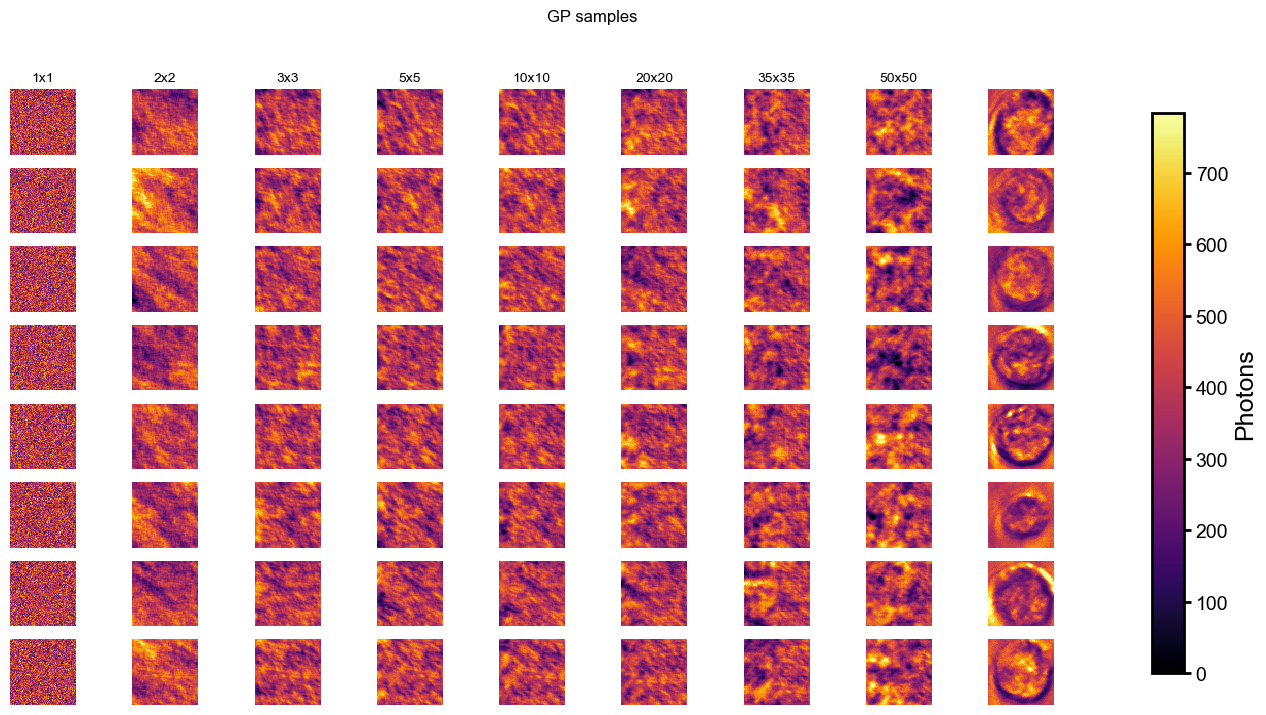

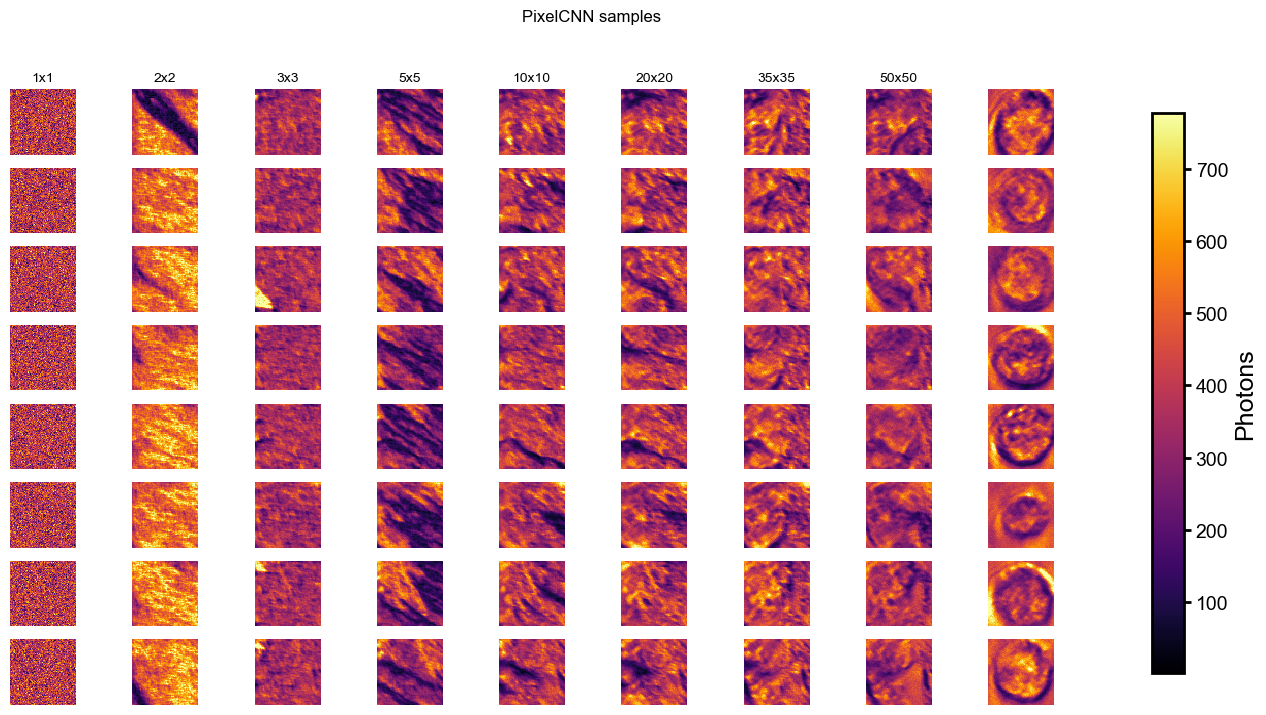

In [4]:
for model_name in ['GP', 'PixelCNN']:
    fig, axs = plt.subplots(num_samples, len(patch_sizes) + 1, figsize=( len(patch_sizes) * 2, num_samples ), sharex=True, sharey=True)
    vmin, vmax = None, None
    for j, patch_size in enumerate(patch_sizes):
        model_samples_for_patch_size = samples[patch_sizes[j]][model_name]
        if vmin is None:
            vmin, vmax = np.percentile(model_samples_for_patch_size, .1), np.percentile(model_samples_for_patch_size, 99.9)
        for i in range(num_samples):
            im = axs[i, j].imshow(model_samples_for_patch_size[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
            axs[i, j].axis('off')

    # show ground truth patch
    display_patches = extract_patches(images, sample_size, num_patches=num_samples, seed=7)
    for i in range(num_samples):
        axs[i, -1].imshow(display_patches[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
        axs[i, -1].axis('off')

    # add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Photons')

    # add a label to each col
    for j, patch_size in enumerate(patch_sizes):
        axs[0, j].set_title(f'{patch_size}x{patch_size}', fontsize=10)
    fig.suptitle(f'{model_name} samples', fontsize=12)

/tmp/ipykernel_31668/3972993745.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))


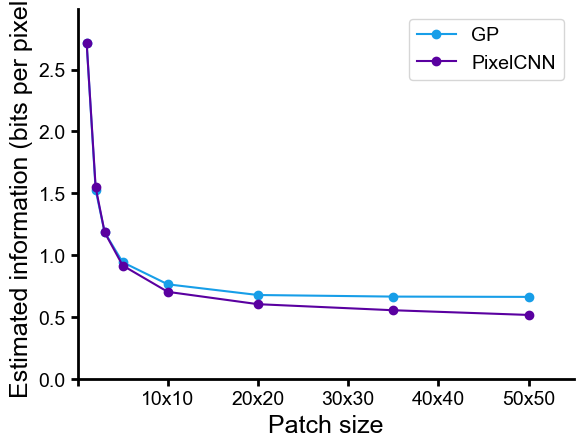

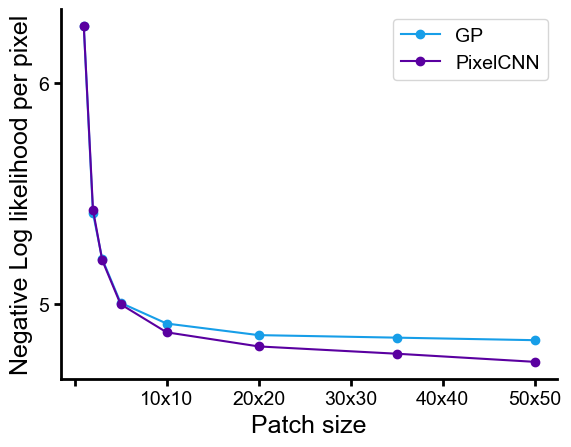

In [5]:
from matplotlib.ticker import MaxNLocator

# Mutual information vs patch size
fig, ax = plt.subplots()
ax.plot(patch_sizes, [mi_estimates_gp[ps] for ps in patch_sizes], 'o-', label='GP')
ax.plot(patch_sizes, [mi_estimates_pixel_cnn[ps] for ps in patch_sizes], 'o-', label='PixelCNN')
clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Estimated information (bits per pixel)', ylim=[0, 1.1 * 
                        max(max(mi_estimates_gp.values()), max(mi_estimates_pixel_cnn.values()))  ],
        xlim=[0, 1.1 * max(patch_sizes)], xticks=np.arange(0, 51, 10))
ax.set(xticklabels=[''] +[f'{ps}x{ps}' for ps in np.arange(10, 51, 10)])
ax.legend()

fig, ax = plt.subplots()
nll_per_pixel_gp = [test_set_NLL_gp[ps] for ps in patch_sizes]
nll_per_pixel_pixel_cnn = [test_set_NLL_pixel_cnn[ps] for ps in patch_sizes]

ax.plot(patch_sizes, nll_per_pixel_gp, 'o-', label='GP')
ax.plot(patch_sizes, nll_per_pixel_pixel_cnn, 'o-', label='PixelCNN')

clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Negative Log likelihood per pixel')
ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
